## 3. Baseline with MW (90 pts)

In [1]:
%load_ext autoreload
%autoreload 2

from queries import query_mw as q_mw
from queries import query_client as q_client
from queries import exp_filter
from queries import network as q_net

from plots.ctrl import generate, dashboard_nc, dashboard_time, export
from plots import tp, rt, utilization, queue, ilaw, sst

suite={
    "exp31":"simulation_p2",
    "exp32":"simulation_p2"
}

%matplotlib inline

output_folder = "result"

In [2]:
def filter_df_nc_w(df, filter_dict):
    
    wo_filter_num_clients = filter_dict['write-only']
    ro_filter_num_clients = filter_dict['read-only']
     
    df = df[((df['workload']=='write-only')&(df['n_worker_per_mw']==8) & (~ df['num_clients'].isin(wo_filter_num_clients[8]))) |
                ((df['workload']=='write-only')&(df['n_worker_per_mw']==16) & (~ df['num_clients'].isin(wo_filter_num_clients[16]))) |
                ((df['workload']=='write-only')&(df['n_worker_per_mw']==32) & (~ df['num_clients'].isin(wo_filter_num_clients[32]))) |
                ((df['workload']=='write-only')&(df['n_worker_per_mw']==64) & (~ df['num_clients'].isin(wo_filter_num_clients[64]))) |
                ((df['workload']=='read-only')&(df['n_worker_per_mw']==8) & (~ df['num_clients'].isin(ro_filter_num_clients[8]))) |
                ((df['workload']=='read-only')&(df['n_worker_per_mw']==16) & (~ df['num_clients'].isin(ro_filter_num_clients[16]))) |
                ((df['workload']=='read-only')&(df['n_worker_per_mw']==32) & (~ df['num_clients'].isin(ro_filter_num_clients[32]))) |
                ((df['workload']=='read-only')&(df['n_worker_per_mw']==64) & (~ df['num_clients'].isin(ro_filter_num_clients[64])))
              ]
    
    return df

### 3.1 One Middleware

In [3]:
import matplotlib.pyplot as plt

def rt_decomposition(df_client, df_mw):
    
    key_col = ['workload', 'n_worker_per_mw', 'num_clients']

    
    df = df_mw.set_index(key_col).join(df_client.set_index(key_col),lsuffix='_mw', rsuffix='_client')
    df = df.reset_index()

    df = df.rename(columns={'rt_rep_mean_mw':'rt_mw',
                            'rt_rep_mean_client':'rt_client',
                            'ntt_rep_mean':'ntt',
                            'qwt_rep_mean':'qwt',
                            'wtt_rep_mean':'wtt',
                            'sst_rep_mean':'sst',
                            'sstmax_rep_mean':'sstmax',
                           })
    
    
    df = df[['workload', 'n_worker_per_mw', 'num_clients', 'rt_client', 'rt_mw', 'ntt', 'qwt', 'wtt', 'sst', 'sstmax']]
    
    df['wtt'] = df['wtt']-df['sst']
    df = df.round(2)
    df['rt_sum'] = df.apply(lambda row: row['ntt'] + row['qwt'] + row ['wtt'] + row['sst'],axis=1)
    df['rt_sum_max'] = df.apply(lambda row: row['ntt'] + row['qwt'] + row ['wtt'] + row['sstmax'],axis=1)
    
    df['diff_rt'] = df['rt_mw']-df['rt_sum']
    df['diffmax_rt'] = df['rt_mw']-df['rt_sum_max']
    
    df = df.round(2)

    return df

def component_utilization(df_mw):
    df = df_mw[['workload', 'n_worker_per_mw', 'num_clients', 'nt_util', 'wt_util', 's_util', 's0_util', 's1_util', 's2_util']]
    df = df.round(2)
    df = df.sort_values(['workload', 'n_worker_per_mw', 'num_clients'])
    display(df)
    return df



        
    

In [4]:
exp_name="exp31"
df_exp31_mw = q_mw.load_df(suite=suite[exp_name], exp=exp_name)
df_exp31_mw = filter_df_nc_w(df=df_exp31_mw, filter_dict=exp_filter.exp31)

df_exp31_client = q_client.load_df(suite=suite[exp_name], exp=exp_name)
df_exp31_client = filter_df_nc_w(df=df_exp31_client, filter_dict=exp_filter.exp31)

In [5]:
df_piv, df = ilaw.interactive_law_mix(df_client=df_exp31_client, df_mw=df_exp31_mw)

display(df_piv)
table = ilaw.table(df_piv, wo_col_count=9, ro_col_count=7)
print(table)

rt_ilaw_diff_wo                                          \
num_clients                 6    12   24   48   72   96   144  192  288   
n_worker_per_mw                                                           
8                           0.0  0.0  0.0  0.1  0.3  0.6    -    -    -   
16                         -0.1  0.0  0.0  0.1  0.1  0.2  0.2  0.4    -   
32                          0.0 -0.1  0.0  0.0  0.0  0.1  0.2  0.2    -   
64                          0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.2  0.9   

                rt_ilaw_diff_ro                                        
num_clients                 6    12   24   48   72   96   144 192 288  
n_worker_per_mw                                                        
8                           0.0  0.1  0.3  0.4  1.3  2.0  1.8   -   -  
16                          0.0  0.0  0.1  0.9  1.2  1.0  1.1   -   -  
32                          0.0  0.0  0.2  0.6  0.5  0.7  1.1   -   -  
64                          0.0  0.0  0.1  0.5  0.5  0.7  1.1   -   -

\begin{tabular}{|cr|*{9}{r}|*{7}{r}|}
\cline{3-18}
\multicolumn{2}{c|}{} & \multicolumn{9}{c|}{number of clients} & \multicolumn{7}{c|}{number of clients} \Tstrut\\
\multicolumn{2}{c|}{} & 6 & 12 & 24 & 48 & 72 & 96 & 144 & 192 & 288 & 6 & 12 & 24 & 48 & 72 & 96 & 144 \\
\hline
\parbox[t]{2mm}{\multirow{4}{*}{\rotatebox[origin=c]{90}{worker}}} & 8 & 0.0 & 0.0 & 0.0 & 0.1 & 0.3 & 0.6 & - & - & - & 0.0 & 0.1 & 0.3 & 0.4 & 1.3 & 2.0 & 1.8\Tstrut\\
& 16 & -0.1 & 0.0 & 0.0 & 0.1 & 0.1 & 0.2 & 0.2 & 0.4 & - & 0.0 & 0.0 & 0.1 & 0.9 & 1.2 & 1.0 & 1.1 \\
& 32 & 0.0 & -0.1 & 0.0 & 0.0 & 0.0 & 0.1 & 0.2 & 0.2 & - & 0.0 & 0.0 & 0.2 & 0.6 & 0.5 & 0.7 & 1.1 \\
& 64 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.1 & 0.2 & 0.9 & 0.0 & 0.0 & 0.1 & 0.5 & 0.5 & 0.7 & 1.1 \\
& & \multicolumn{9}{c|}{in milliseconds} & \multicolumn{7}{c|}{in milliseconds}\\
\hline
\multicolumn{2}{c}{} & \multicolumn{9}{c}{write-only} & \multicolumn{7}{c}{read-only} \Tstrut\\ 
\end{tabular}


#### Write-Only

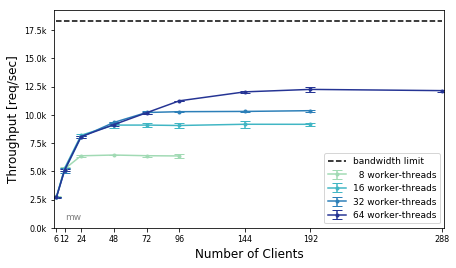

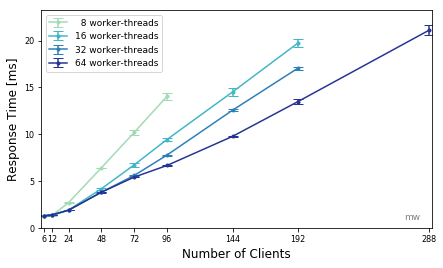

Saved Data: ./../../data/exp31/write_only/processed_mw.log
Saved Data: ./../../data/exp31/write_only/processed_client.log
MW: 


n_worker_per_mw          8                                               16  \
num_clients             6       12      24      48      72      96      6     
throughput_rep_mean  2779.7  5207.3  6371.9  6440.1  6379.2  6357.8  2701.6   
rt_rep_mean             1.2     1.3     2.7     6.4    10.2    14.0     1.3   
qwt_rep_mean            0.1     0.2     1.4     5.2     8.9    12.8     0.1   
queue_rep_mean          0.3     0.9     9.9    33.4    56.8    81.8     0.3   

n_worker_per_mw                                                              \
num_clients             12      24      48      72      96      144     192   
throughput_rep_mean  5270.1  8189.6  9088.2  9091.1  9053.9  9162.6  9158.6   
rt_rep_mean             1.3     1.9     4.2     6.7     9.4    14.5    19.7   
qwt_rep_mean            0.1     0.4     2.4     4.9     7.6    12.7    18.0   
queue_rep_mean          1.1     3.3    23.9    44.4    69.9   115.5   164.9   

n_worker_per_mw          32                                            \
num_clients             6       12      24      48       72       96    
throughput_rep_mean  2720.3  5057.4  8024.6  9321.8  10203.6  10275.2   
rt_rep_mean             1.3     1.4     1.9     3.8      5.6      7.8   
qwt_rep_mean            0.1     0.1     0.3     1.0      2.5      4.6   
queue_rep_mean          0.2     0.7     1.6     7.3     24.6     47.1   

n_worker_per_mw                            64                          \
num_clients              144      192     6       12      24      48    
throughput_rep_mean  10298.7  10364.8  2700.1  5130.6  8066.6  9125.9   
rt_rep_mean             12.6     17.1     1.3     1.4     1.9     3.8   
qwt_rep_mean             9.4     14.0     0.1     0.1     0.3     0.6   
queue_rep_mean          92.6    142.4     0.1     0.6     2.1     4.4   

n_worker_per_mw                                                   
num_clients              72       96       144      192      288  
throughput_rep_mean  10182.3  11236.1  12030.3  12247.8  12139.5  
rt_rep_mean              5.4      6.7      9.8     13.5     21.1  
qwt_rep_mean             1.2      2.0      4.6      8.3     15.8  
queue_rep_mean          14.5     20.1     65.3    105.1    202.5

Client: 


n_worker_per_mw          8                                               16  \
num_clients             6       12      24      48      72      96      6     
throughput_rep_mean  2752.6  5134.3  6378.3  6532.7  6545.6  6610.9  2650.4   
rt_rep_mean             2.2     2.3     3.8     7.4    11.0    14.5     2.3   

n_worker_per_mw                                                              \
num_clients             12      24      48      72      96      144     192   
throughput_rep_mean  5211.9  8123.5  9178.9  9200.7  9240.5  9282.4  9356.7   
rt_rep_mean             2.3     3.0     5.2     7.8    10.4    15.5    20.6   

n_worker_per_mw          32                                            \
num_clients             6       12      24      48       72       96    
throughput_rep_mean  2685.8  4947.9  7961.5  9347.9  10253.7  10350.1   
rt_rep_mean             2.2     2.4     3.0     5.1      7.0      9.2   

n_worker_per_mw                            64                          \
num_clients              144      192     6       12      24      48    
throughput_rep_mean  10429.7  10466.0  2659.6  5059.4  7972.4  9084.9   
rt_rep_mean             13.8     18.3     2.3     2.4     3.0     5.3   

n_worker_per_mw                                                  
num_clients              72       96       144      192     288  
throughput_rep_mean  10197.6  11271.8  12144.6  11070.2  9723.0  
rt_rep_mean              7.0      8.5     11.8     15.5    22.9

- differences in throughput because of exclusion of warm up and cooldown phase
- rt longer because cannot measure rtt client - mw -client
Number of Worker: 8


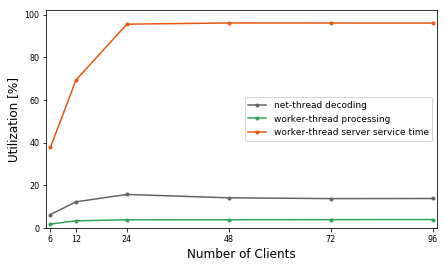

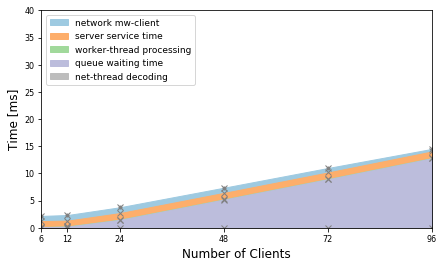

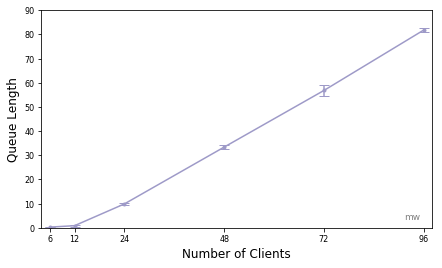

Number of Worker: 16


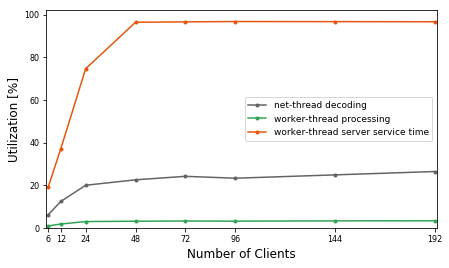

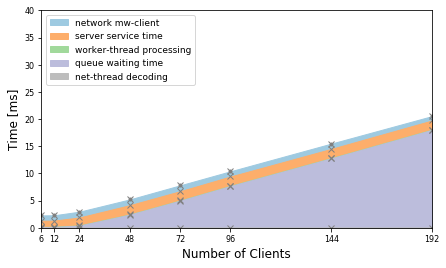

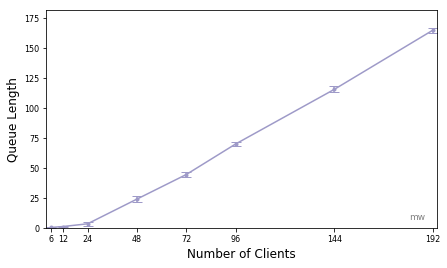

Number of Worker: 32


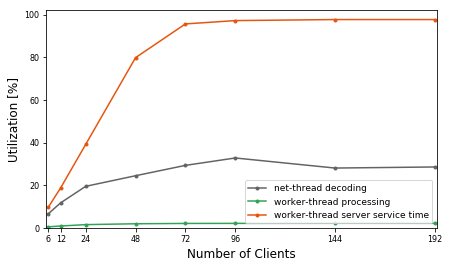

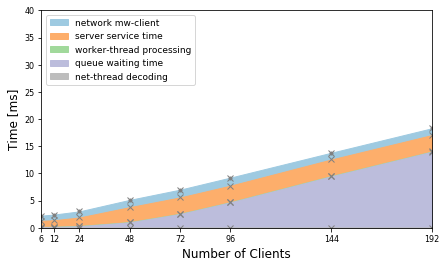

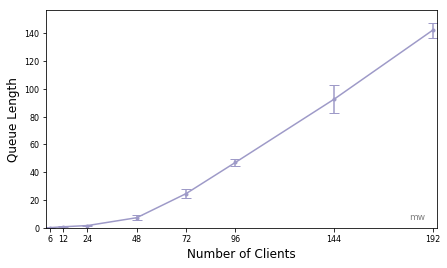

Number of Worker: 64


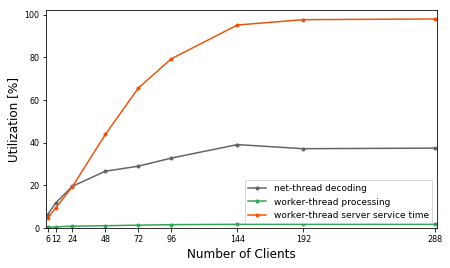

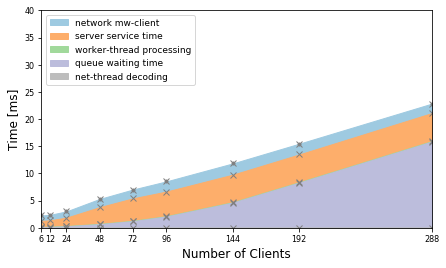

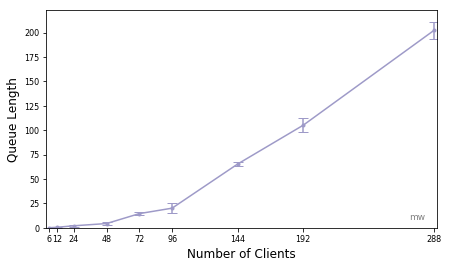

In [6]:
exp_name="exp31"
df_exp31_wo_mw = df_exp31_mw[df_exp31_mw['workload']=='write-only']
df_exp31_wo_c = df_exp31_client[df_exp31_client['workload']=='write-only']
    

generate(tp.nc_w, df_exp31_wo_mw, output_folder, f"{exp_name}_wo_tp_nc_w")
generate(rt.nc_w, df_exp31_wo_mw, output_folder, f"{exp_name}_wo_rt_nc_w")

export(df_exp31_wo_mw, "write_only", exp_name="exp31", suffix="_mw")
export(df_exp31_wo_c, "write_only", exp_name="exp31", suffix="_client")

print("MW: ")
display(df_exp31_wo_mw[['n_worker_per_mw', 'num_clients', 'throughput_rep_mean','rt_rep_mean', 'qwt_rep_mean', 'queue_rep_mean']].sort_values(['n_worker_per_mw', 'num_clients']).set_index(['n_worker_per_mw','num_clients']).transpose().round(1))

print("Client: ")
display(df_exp31_wo_c[['n_worker_per_mw', 'num_clients', 'throughput_rep_mean','rt_rep_mean']].sort_values(['n_worker_per_mw', 'num_clients']).set_index(['n_worker_per_mw','num_clients']).transpose().round(1))

print("- differences in throughput because of exclusion of warm up and cooldown phase")
print("- rt longer because cannot measure rtt client - mw -client")

df = rt_decomposition(df_client=df_exp31_wo_c, df_mw=df_exp31_wo_mw)
for n_worker in [8, 16, 32, 64]:
    print(f"Number of Worker: {n_worker}")
    generate(utilization.nc, df_exp31_wo_mw[df_exp31_wo_mw['n_worker_per_mw']==n_worker], output_folder, f"{exp_name}_wo_util_nc_w{n_worker}")
    generate(rt.component_nc, df[df['n_worker_per_mw']==n_worker], output_folder, f"{exp_name}_wo_component_nc_w{n_worker}", opt=40)
    generate(queue.nc, df_exp31_wo_mw[df_exp31_wo_mw['n_worker_per_mw']==n_worker], output_folder, f"{exp_name}_wo_queue_size_nc_w{n_worker}")

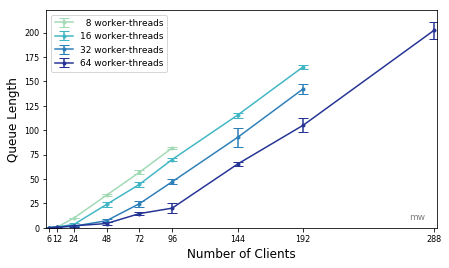

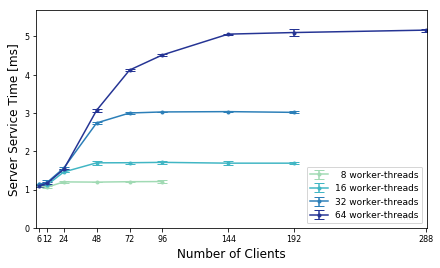

Number of Worker: 8


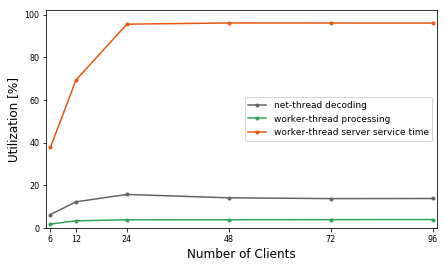

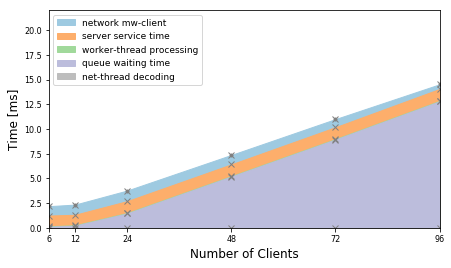

Number of Worker: 16


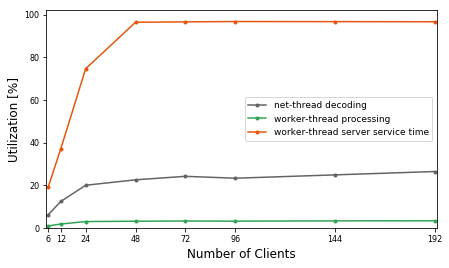

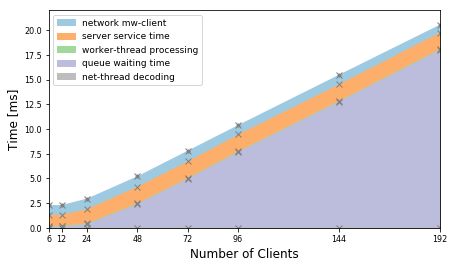

Number of Worker: 32


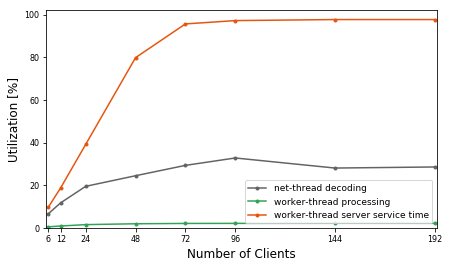

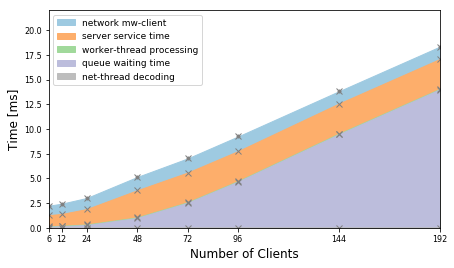

Number of Worker: 64


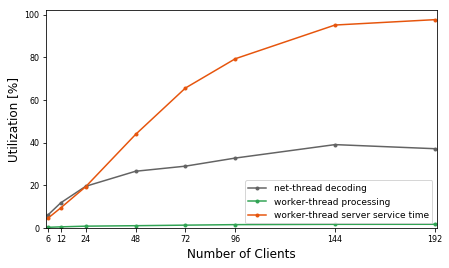

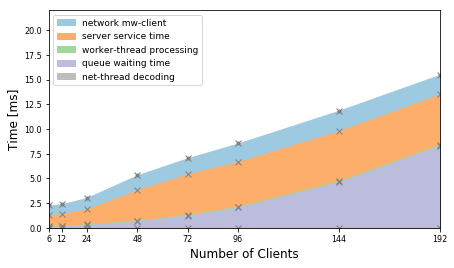

In [7]:
exp_name="exp31"
generate(queue.nc_w, df_exp31_wo_mw, output_folder, f"{exp_name}_wo_queue_nc_w", figsize=3)
generate(sst.nc_w, df_exp31_wo_mw, output_folder, f"{exp_name}_wo_sst_nc_w", figsize=3)

df = rt_decomposition(df_client=df_exp31_wo_c, df_mw=df_exp31_wo_mw)
for n_worker in [8, 16, 32, 64]:
    print(f"Number of Worker: {n_worker}")
    generate(utilization.nc, df_exp31_wo_mw[~(df_exp31_wo_mw['num_clients']==288)&(df_exp31_wo_mw['n_worker_per_mw']==n_worker)], output_folder, f"{exp_name}_wo_util_nc_w{n_worker}")
    generate(rt.component_nc, df[~(df['num_clients']==288)&(df['n_worker_per_mw']==n_worker)], output_folder, f"{exp_name}_wo_component_nc_w{n_worker}", opt = 22)

#### Read-Only

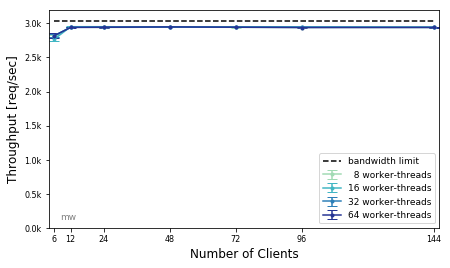

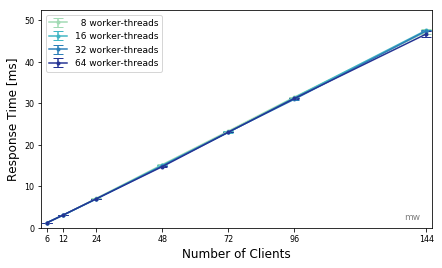

Saved Data: ./../../data/exp31/read_only/processed_mw.log
Saved Data: ./../../data/exp31/read_only/processed_client.log
MW: 


n_worker_per_mw          8                                                   \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2813.8  2945.2  2940.2  2945.2  2942.4  2939.9  2940.5   
rt_rep_mean             1.2     3.1     7.1    15.2    23.3    31.5    47.3   
qwt_rep_mean            0.1     0.7     4.4    12.5    20.6    28.8    44.6   
queue_rep_mean          0.4     0.5    12.1    38.3    60.2    83.4   130.5   

n_worker_per_mw          16                                                  \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2767.7  2951.6  2951.7  2947.5  2951.3  2948.4  2945.8   
rt_rep_mean             1.2     3.1     7.0    15.1    23.0    31.4    47.7   
qwt_rep_mean            0.1     0.2     2.0     9.6    17.6    25.9    42.2   
queue_rep_mean          0.4     0.2     6.7    29.4    54.4    78.4   125.4   

n_worker_per_mw          32                                                  \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2818.7  2945.2  2948.1  2950.1  2944.2  2944.8  2941.8   
rt_rep_mean             1.2     3.1     7.0    14.9    23.1    31.0    47.5   
qwt_rep_mean            0.1     0.1     0.3     4.7    12.2    20.1    36.6   
queue_rep_mean          0.3     0.3     0.1    11.4    39.6    63.1   111.9   

n_worker_per_mw          64                                                  
num_clients             6       12      24      48      72      96      144  
throughput_rep_mean  2820.0  2940.8  2943.0  2948.0  2944.0  2939.1  2941.0  
rt_rep_mean             1.2     3.1     7.0    14.8    23.0    31.2    46.7  
qwt_rep_mean            0.1     0.1     0.4     1.2     3.2     9.7    25.0  
queue_rep_mean          0.4     0.1     1.1     0.0     7.4    27.3    74.9

Client: 


n_worker_per_mw          8                                                   \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2779.8  3007.8  3043.5  3010.0  3096.1  3123.3  3053.6   
rt_rep_mean             2.2     4.0     7.9    15.9    23.2    30.7    47.2   

n_worker_per_mw          16                                                  \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2722.3  2990.4  3006.4  3138.8  3104.0  3049.8  3020.3   
rt_rep_mean             2.2     4.0     8.0    15.3    23.2    31.5    47.8   

n_worker_per_mw          32                                                  \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2779.1  2973.8  3030.3  3074.8  3006.5  3014.0  3008.5   
rt_rep_mean             2.2     4.1     7.9    15.7    24.0    31.9    47.9   

n_worker_per_mw          64                                                  
num_clients             6       12      24      48      72      96      144  
throughput_rep_mean  2797.5  2966.9  2997.4  3034.5  3018.9  3018.7  3010.1  
rt_rep_mean             2.2     4.1     8.0    15.8    24.0    32.0    47.9

Number of Worker: 8


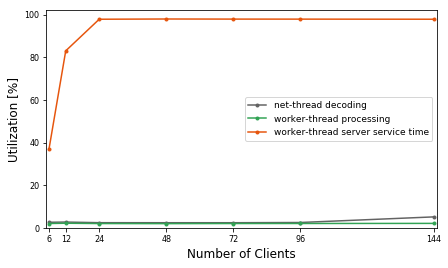

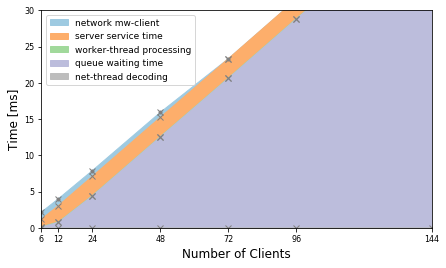

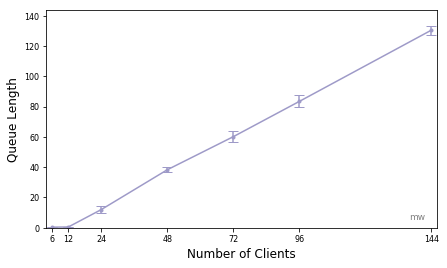

Number of Worker: 16


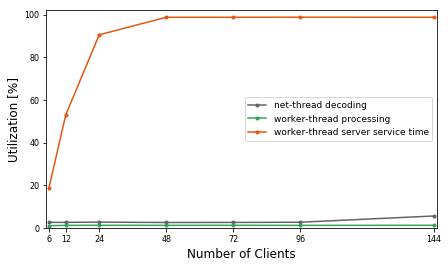

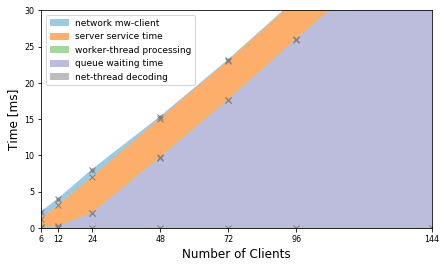

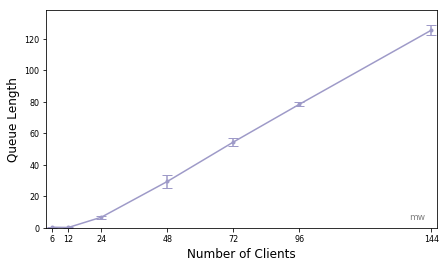

Number of Worker: 32


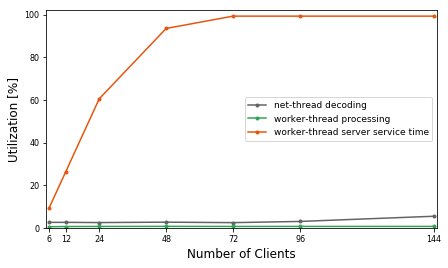

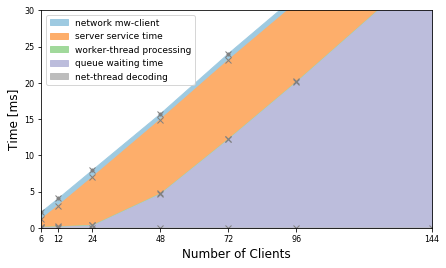

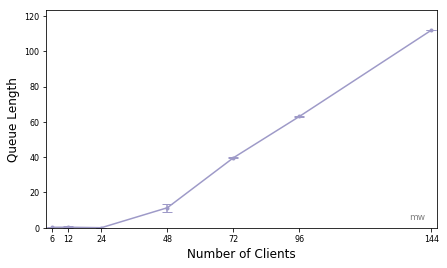

Number of Worker: 64


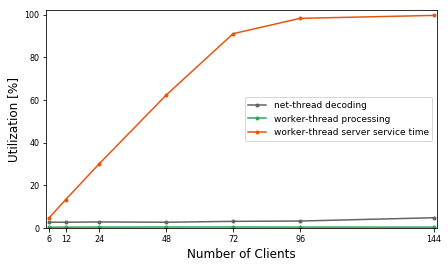

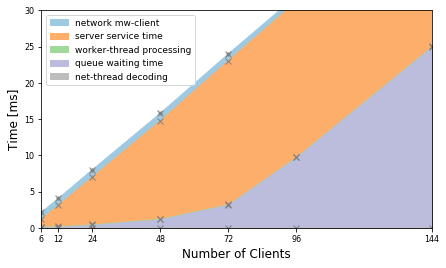

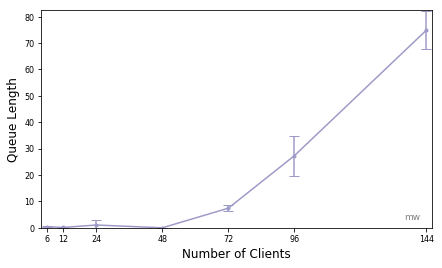

In [8]:
df_exp31_ro_mw = df_exp31_mw[df_exp31_mw['workload']=='read-only']
df_exp31_ro_c = df_exp31_client[df_exp31_client['workload']=='read-only']


generate(tp.nc_w, df_exp31_ro_mw, output_folder, f"{exp_name}_ro_tp_nc_w")
generate(rt.nc_w, df_exp31_ro_mw, output_folder, f"{exp_name}_ro_rt_nc_w")

export(df_exp31_ro_mw, "read_only", exp_name="exp31", suffix="_mw")
export(df_exp31_ro_c, "read_only", exp_name="exp31", suffix="_client")


print("MW: ")
display(df_exp31_ro_mw[['n_worker_per_mw', 'num_clients', 'throughput_rep_mean','rt_rep_mean', 'qwt_rep_mean', 'queue_rep_mean']].sort_values(['n_worker_per_mw', 'num_clients']).set_index(['n_worker_per_mw','num_clients']).transpose().round(1))

print("Client: ")
display(df_exp31_ro_c[['n_worker_per_mw', 'num_clients', 'throughput_rep_mean','rt_rep_mean']].sort_values(['n_worker_per_mw', 'num_clients']).set_index(['n_worker_per_mw','num_clients']).transpose().round(1))

df = rt_decomposition(df_client=df_exp31_ro_c, df_mw=df_exp31_ro_mw)
for n_worker in [8, 16, 32, 64]:
    print(f"Number of Worker: {n_worker}")
    generate(utilization.nc, df_exp31_ro_mw[df_exp31_ro_mw['n_worker_per_mw']==n_worker])
    generate(rt.component_nc, df[df['n_worker_per_mw']==n_worker], opt=30)
    generate(queue.nc, df_exp31_ro_mw[df_exp31_ro_mw['n_worker_per_mw']==n_worker])

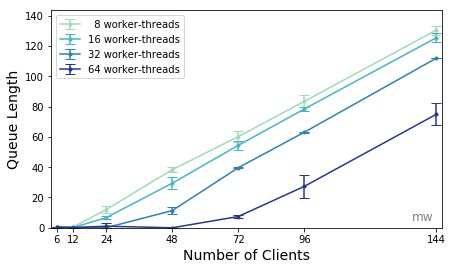

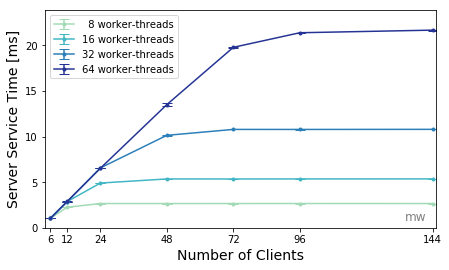

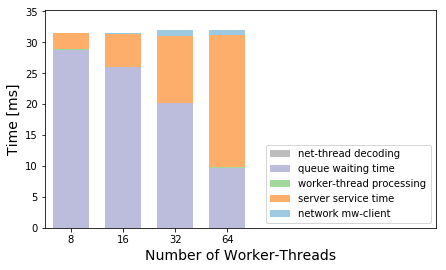

In [9]:
generate(queue.nc_w, df_exp31_ro_mw, output_folder, f"{exp_name}_ro_queue_nc_w", n_fig=3)
generate(sst.nc_w, df_exp31_ro_mw, output_folder, f"{exp_name}_ro_sst_nc_w", n_fig=3)
df = rt_decomposition(df_client=df_exp31_ro_c, df_mw=df_exp31_ro_mw)
generate(rt.component_w, df[df['num_clients']==96], output_folder, f"{exp_name}_ro_rt_component_w", n_fig=3)

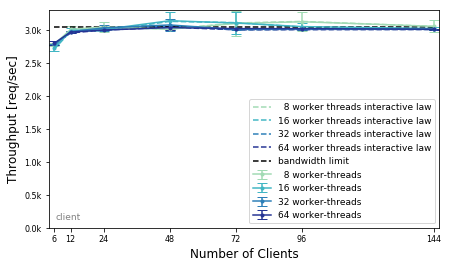

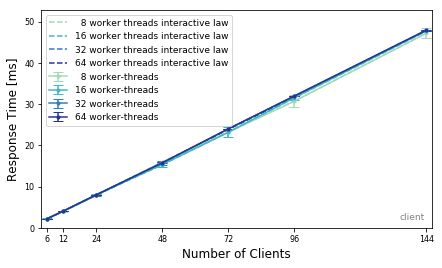

In [10]:
generate(tp.nc_w, df_exp31_ro_c)
generate(rt.nc_w, df_exp31_ro_c)

#### 3.1.1 Explanation

### 3.2 Two Middlewares

In [11]:
exp_name="exp32"
df_exp32_mw = q_mw.load_df(suite=suite[exp_name], exp=exp_name)
df_exp32_mw = filter_df_nc_w(df=df_exp32_mw, filter_dict=exp_filter.exp32)

df_exp32_client = q_client.load_df(suite=suite[exp_name], exp=exp_name)
df_exp32_client = filter_df_nc_w(df=df_exp32_client, filter_dict=exp_filter.exp32)

#### Interactive Law

$R =  \frac{N}{X}-Z$

with $Z=0$, using the throughput measured in the middleware $X=X_{mw}$ and calculate the response time we should see on the client $R_{client}$

$R_{client} -  \frac{N}{X_{mw}}$

In [12]:
df_piv, df = ilaw.interactive_law_mix(df_client=df_exp32_client, df_mw=df_exp32_mw)
display(df_piv)
table = ilaw.table(df_piv, wo_col_count=10, ro_col_count=7)
print(table)

display(q_net.stats(suite=suite[exp_name], exp="exp31"))
display(q_net.stats(suite=suite[exp_name], exp="exp32"))

rt_ilaw_diff_wo                                               \
num_clients                 6    12   24   48   72   96   144  192  288  384   
n_worker_per_mw                                                                
8                           0.0  0.0  0.0  0.1  0.2  0.4  0.6  0.7  1.1    -   
16                          0.0  0.0  0.0  0.0  0.1  0.1  0.3  0.5  0.9    -   
32                          0.0  0.0  0.0  0.0  0.1  0.2  0.3  0.4  0.6    -   
64                         -0.1  0.0  0.0  0.1  0.1  0.1  0.3  0.2  0.4  0.3   

                rt_ilaw_diff_ro                                            
num_clients                 6    12   24   48   72   96   144 192 288 384  
n_worker_per_mw                                                            
8                           0.0  0.0  0.2  0.8  1.0  1.4  2.0   -   -   -  
16                          0.0  0.0  0.3  0.6  1.1  1.6  1.9   -   -   -  
32                          0.0  0.1  0.4  1.0  1.2  1.6  2.9   -   -   -  
64                          0.0  0.1  0.3  0.8  1.1  1.4  2.5   -   -   -

\begin{tabular}{|cr|*{10}{r}|*{7}{r}|}
\cline{3-19}
\multicolumn{2}{c|}{} & \multicolumn{10}{c|}{number of clients} & \multicolumn{7}{c|}{number of clients} \Tstrut\\
\multicolumn{2}{c|}{} & 6 & 12 & 24 & 48 & 72 & 96 & 144 & 192 & 288 & 384 & 6 & 12 & 24 & 48 & 72 & 96 & 144 \\
\hline
\parbox[t]{2mm}{\multirow{4}{*}{\rotatebox[origin=c]{90}{worker}}} & 8 & 0.0 & 0.0 & 0.0 & 0.1 & 0.2 & 0.4 & 0.6 & 0.7 & 1.1 & - & 0.0 & 0.0 & 0.2 & 0.8 & 1.0 & 1.4 & 2.0\Tstrut\\
& 16 & 0.0 & 0.0 & 0.0 & 0.0 & 0.1 & 0.1 & 0.3 & 0.5 & 0.9 & - & 0.0 & 0.0 & 0.3 & 0.6 & 1.1 & 1.6 & 1.9 \\
& 32 & 0.0 & 0.0 & 0.0 & 0.0 & 0.1 & 0.2 & 0.3 & 0.4 & 0.6 & - & 0.0 & 0.1 & 0.4 & 1.0 & 1.2 & 1.6 & 2.9 \\
& 64 & -0.1 & 0.0 & 0.0 & 0.1 & 0.1 & 0.1 & 0.3 & 0.2 & 0.4 & 0.3 & 0.0 & 0.1 & 0.3 & 0.8 & 1.1 & 1.4 & 2.5 \\
& & \multicolumn{10}{c|}{in milliseconds} & \multicolumn{7}{c|}{in milliseconds}\\
\hline
\multicolumn{2}{c}{} & \multicolumn{10}{c}{write-only} & \multicolumn{7}{c}{read-only} \Tstrut\\ 
\end{tabular}


[{'from': 'Client1', 'to': 'Middleware1', 'bandwidth': 201.0, 'rtt': 1.444},
 {'from': 'Client2', 'to': 'Middleware1', 'bandwidth': 200.0, 'rtt': 1.883},
 {'from': 'Client3', 'to': 'Middleware1', 'bandwidth': 199.5, 'rtt': 2.184},
 {'from': 'Middleware1', 'to': 'Client1', 'bandwidth': 423.0, 'rtt': 1.512},
 {'from': 'Middleware1', 'to': 'Client2', 'bandwidth': 174.5, 'rtt': 1.48},
 {'from': 'Middleware1', 'to': 'Client3', 'bandwidth': 215.5, 'rtt': 1.194},
 {'from': 'Middleware1', 'to': 'Server1', 'bandwidth': 798.5, 'rtt': 1.595},
 {'from': 'Server1', 'to': 'Middleware1', 'bandwidth': 99.6, 'rtt': 1.367}]

[{'from': 'Client1', 'to': 'Middleware1', 'bandwidth': 110.0, 'rtt': 1.467},
 {'from': 'Client1', 'to': 'Middleware2', 'bandwidth': 89.85, 'rtt': 1.295},
 {'from': 'Client2', 'to': 'Middleware1', 'bandwidth': 109.0, 'rtt': 1.403},
 {'from': 'Client2', 'to': 'Middleware2', 'bandwidth': 91.0, 'rtt': 1.453},
 {'from': 'Client3', 'to': 'Middleware1', 'bandwidth': 102.5, 'rtt': 0.976},
 {'from': 'Client3', 'to': 'Middleware2', 'bandwidth': 95.85, 'rtt': 1.029},
 {'from': 'Middleware1', 'to': 'Client1', 'bandwidth': 427.0, 'rtt': 1.222},
 {'from': 'Middleware1', 'to': 'Client2', 'bandwidth': 172.0, 'rtt': 1.523},
 {'from': 'Middleware1', 'to': 'Client3', 'bandwidth': 218.0, 'rtt': 0.975},
 {'from': 'Middleware2', 'to': 'Client1', 'bandwidth': 410.0, 'rtt': 1.227},
 {'from': 'Middleware2', 'to': 'Client2', 'bandwidth': 164.5, 'rtt': 1.347},
 {'from': 'Middleware2', 'to': 'Client3', 'bandwidth': 236.5, 'rtt': 0.948},
 {'from': 'Middleware1', 'to': 'Server1', 'bandwidth': 688.0, 'rtt': 1.278},


#### Write-Only

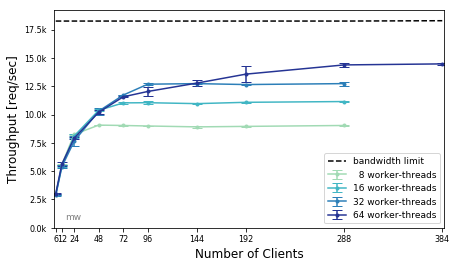

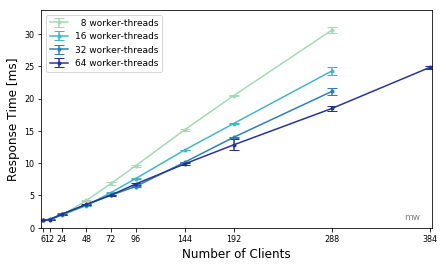

Saved Data: ./../../data/exp32/write_only/processed_mw.log
Saved Data: ./../../data/exp32/write_only/processed_client.log
MW: 


n_worker_per_mw          8                                                   \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2880.5  5596.6  8244.0  9068.1  9035.8  8990.0  8911.8   
rt_rep_mean             1.2     1.2     1.9     4.2     6.9     9.6    15.2   
qwt_rep_mean            0.1     0.1     0.4     2.4     5.1     7.8    13.3   
queue_rep_mean          0.2     0.1     1.2    11.1    22.8    35.3    58.7   
wtt_rep_mean            1.1     1.1     1.6     1.8     1.8     1.8     1.8   
sst_rep_mean            1.0     1.1     1.5     1.7     1.7     1.7     1.7   

n_worker_per_mw                          16                                    \
num_clients             192     288     6       12      24       48       72    
throughput_rep_mean  8954.6  9035.6  2946.1  5446.8  8099.6  10373.1  11029.8   
rt_rep_mean            20.4    30.6     1.2     1.3     2.0      3.4      5.4   
qwt_rep_mean           18.6    28.8     0.1     0.1     0.1      0.7      2.5   
queue_rep_mean         83.6   129.9     0.0     0.1     0.4      3.8     13.9   
wtt_rep_mean            1.8     1.8     1.1     1.2     1.8      2.7      2.9   
sst_rep_mean            1.7     1.7     1.0     1.1     1.8      2.6      2.8   

n_worker_per_mw                                              32          \
num_clients              96       144      192      288     6       12    
throughput_rep_mean  11046.6  10964.1  11081.2  11148.7  2856.6  5394.6   
rt_rep_mean              7.6     12.0     16.1     24.3     1.2     1.3   
qwt_rep_mean             4.7      9.1     13.2     21.4     0.1     0.1   
queue_rep_mean          25.8     50.7     71.9    119.1     0.1     0.3   
wtt_rep_mean             2.9      2.9      2.9      2.9     1.1     1.2   
sst_rep_mean             2.8      2.9      2.8      2.8     1.1     1.1   

n_worker_per_mw                                                           \
num_clients             24       48       72       96       144      192   
throughput_rep_mean  7648.1  10298.8  11719.6  12680.9  12731.0  12649.7   
rt_rep_mean             2.1      3.6      5.0      6.4     10.1     14.0   
qwt_rep_mean            0.1      0.3      0.6      1.6      5.1      8.9   
queue_rep_mean          0.4      1.2      3.2     10.3     34.0     57.9   
wtt_rep_mean            2.0      3.3      4.4      4.7      5.0      5.1   
sst_rep_mean            1.9      3.2      4.4      4.6      4.9      5.0   

n_worker_per_mw                   64                                    \
num_clients              288     6       12      24       48       72    
throughput_rep_mean  12732.2  3012.2  5632.2  7920.0  10202.4  11565.7   
rt_rep_mean             21.1     1.1     1.2     2.1      3.6      5.1   
qwt_rep_mean            16.1     0.1     0.1     0.1      0.3      0.4   
queue_rep_mean         102.1     0.0     0.2     0.6      1.3      1.6   
wtt_rep_mean             5.0     1.1     1.1     1.9      3.3      4.7   
sst_rep_mean             4.9     1.0     1.1     1.9      3.3      4.6   

n_worker_per_mw                                                   
num_clients              96       144      192      288      384  
throughput_rep_mean  12038.2  12777.4  13569.0  14383.3  14473.8  
rt_rep_mean              6.8      9.9     12.8     18.5     24.8  
qwt_rep_mean             0.5      0.9      3.5      9.6     16.0  
queue_rep_mean           2.5      6.2     23.6     71.7    113.8  
wtt_rep_mean             6.3      8.9      9.3      8.8      8.8  
sst_rep_mean             6.2      8.9      9.3      8.8      8.7

Client: 


n_worker_per_mw          8                                                   \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2843.1  5492.3  8187.7  9276.8  9338.7  9307.5  9245.7   
rt_rep_mean             2.1     2.2     2.9     5.2     7.7    10.3    15.6   

n_worker_per_mw                          16                                    \
num_clients             192     288     6       12      24       48       72    
throughput_rep_mean  9273.8  9359.9  2904.0  5364.0  8086.3  10428.0  11148.9   
rt_rep_mean            20.7    30.8     2.1     2.2     3.0      4.6      6.4   

n_worker_per_mw                                              32          \
num_clients              96       144      192      288     6       12    
throughput_rep_mean  11190.1  11241.1  11421.8  11581.2  2815.4  5369.2   
rt_rep_mean              8.6     12.8     16.8     24.9     2.1     2.2   

n_worker_per_mw                                                           \
num_clients             24       48       72       96       144      192   
throughput_rep_mean  7723.3  10431.7  11937.2  12962.1  13087.3  12976.9   
rt_rep_mean             3.2      4.6      6.1      7.4     11.0     14.8   

n_worker_per_mw                   64                                    \
num_clients              288     6       12      24       48       72    
throughput_rep_mean  13085.1  2965.2  5581.7  7917.4  10388.0  11846.4   
rt_rep_mean             22.0     2.0     2.2     3.0      4.6      6.1   

n_worker_per_mw                                                   
num_clients              96       144      192      288      384  
throughput_rep_mean  12268.7  13148.9  13775.8  14707.8  14624.5  
rt_rep_mean              7.8     10.9     14.0     19.6     26.3

Number of Worker: 8


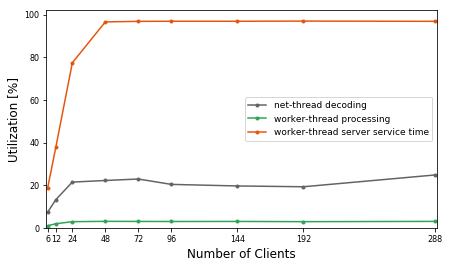

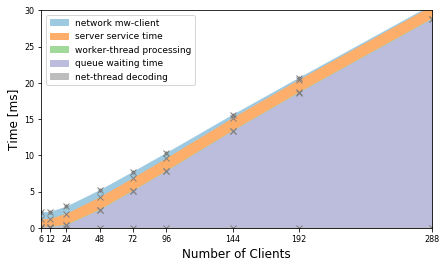

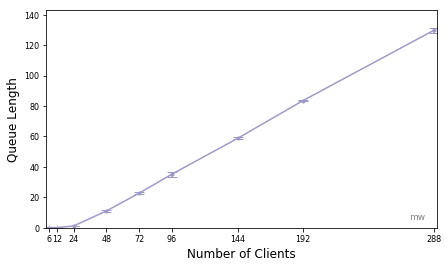

Number of Worker: 16


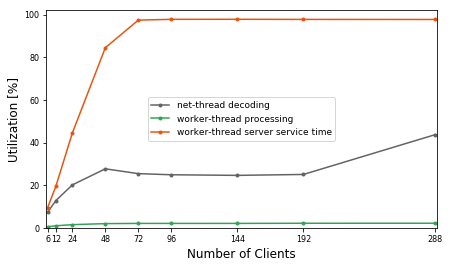

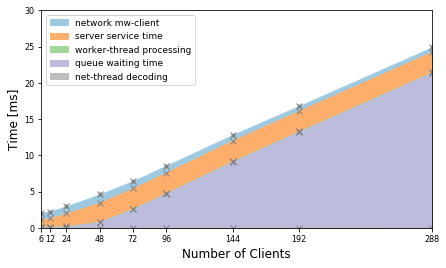

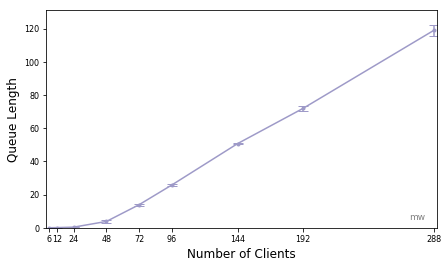

Number of Worker: 32


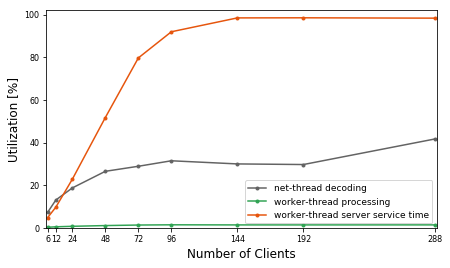

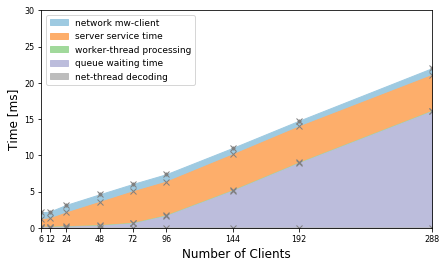

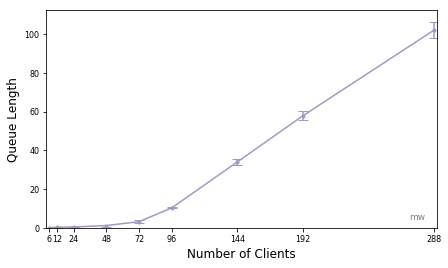

Number of Worker: 64


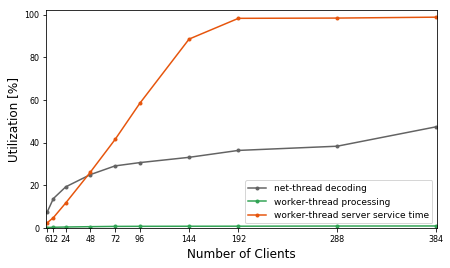

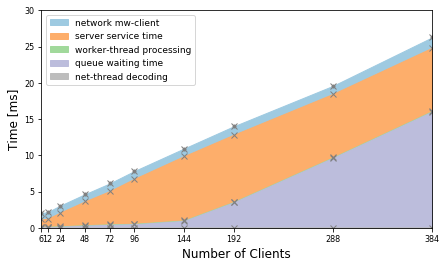

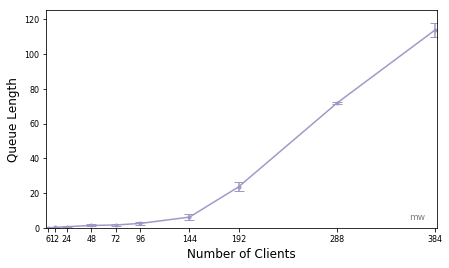

In [13]:
exp_name="exp32"
df_exp32_wo_mw = df_exp32_mw[df_exp32_mw['workload']=='write-only']
df_exp32_wo_c = df_exp32_client[df_exp32_client['workload']=='write-only']


generate(tp.nc_w, df_exp32_wo_mw, output_folder, f"{exp_name}_wo_tp_nc_w") 
generate(rt.nc_w, df_exp32_wo_mw, output_folder, f"{exp_name}_wo_rt_nc_w") 

export(df_exp32_wo_mw, "write_only", exp_name="exp32", suffix="_mw")
export(df_exp32_wo_c, "write_only", exp_name="exp32", suffix="_client")


print("MW: ")
display(df_exp32_wo_mw[['n_worker_per_mw', 'num_clients', 'throughput_rep_mean','rt_rep_mean', 'qwt_rep_mean', 'queue_rep_mean', 'wtt_rep_mean', 'sst_rep_mean']].sort_values(['n_worker_per_mw', 'num_clients']).set_index(['n_worker_per_mw','num_clients']).transpose().round(1))

print("Client: ")
display(df_exp32_wo_c[['n_worker_per_mw', 'num_clients', 'throughput_rep_mean','rt_rep_mean']].sort_values(['n_worker_per_mw', 'num_clients']).set_index(['n_worker_per_mw','num_clients']).transpose().round(1))



df = rt_decomposition(df_client=df_exp32_wo_c, df_mw=df_exp32_wo_mw)
for n_worker in [8, 16, 32, 64]:
    print(f"Number of Worker: {n_worker}")
    generate(utilization.nc, df_exp32_wo_mw[df_exp32_wo_mw['n_worker_per_mw']==n_worker], output_folder, f"{exp_name}_wo_util_nc_w{n_worker}")
    generate(rt.component_nc, df[df['n_worker_per_mw']==n_worker], output_folder, f"{exp_name}_wo_component_nc_w{n_worker}", opt = 30)
    generate(queue.nc, df_exp32_wo_mw[df_exp32_wo_mw['n_worker_per_mw']==n_worker], output_folder, f"{exp_name}_wo_queue_size_nc_w{n_worker}")



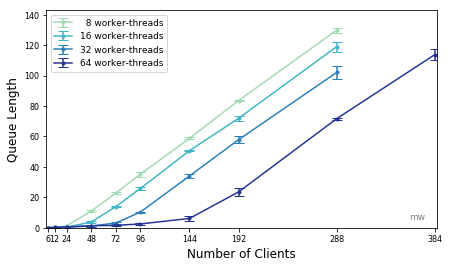

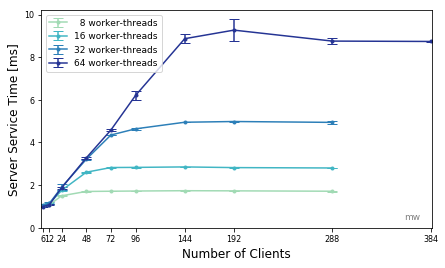

Number of Worker: 8


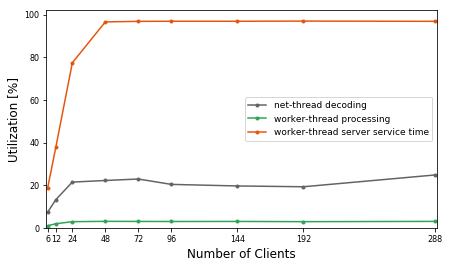

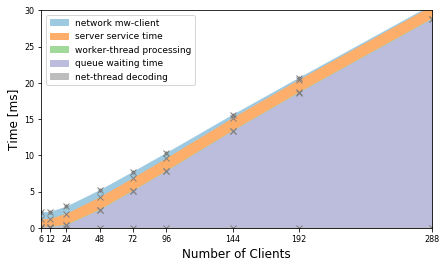

Number of Worker: 16


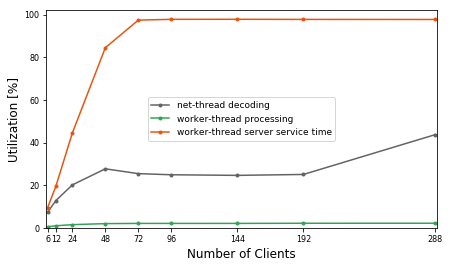

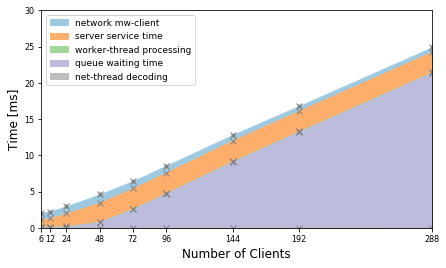

Number of Worker: 32


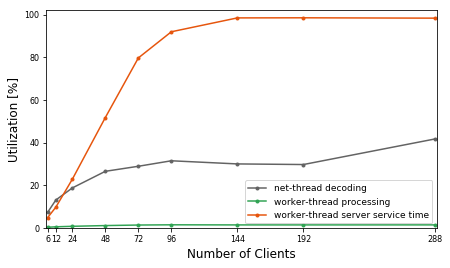

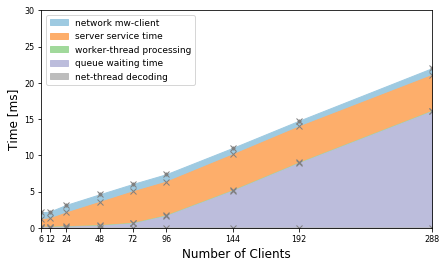

Number of Worker: 64


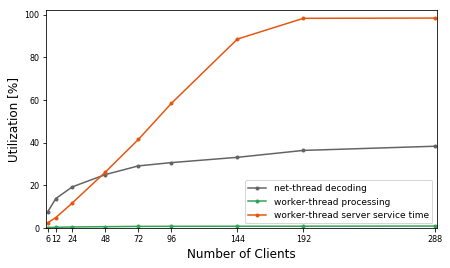

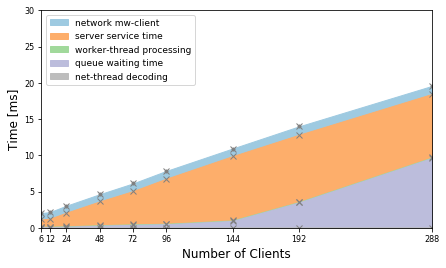

In [14]:
exp_name="exp32"
generate(queue.nc_w, df_exp32_wo_mw, output_folder, f"{exp_name}_wo_queue_nc_w", figsize=3)
generate(sst.nc_w, df_exp32_wo_mw, output_folder, f"{exp_name}_wo_sst_nc_w", figsize=3)

df = rt_decomposition(df_client=df_exp32_wo_c, df_mw=df_exp32_wo_mw)
for n_worker in [8, 16, 32, 64]:
    print(f"Number of Worker: {n_worker}")
    generate(utilization.nc, df_exp32_wo_mw[~(df_exp32_wo_mw['num_clients']==384)&(df_exp32_wo_mw['n_worker_per_mw']==n_worker)], output_folder, f"{exp_name}_wo_util_nc_w{n_worker}")
    generate(rt.component_nc, df[~(df['num_clients']==384)&(df['n_worker_per_mw']==n_worker)], output_folder, f"{exp_name}_wo_component_nc_w{n_worker}", opt = 30)

#### Read-Only

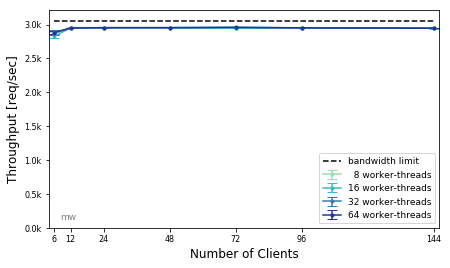

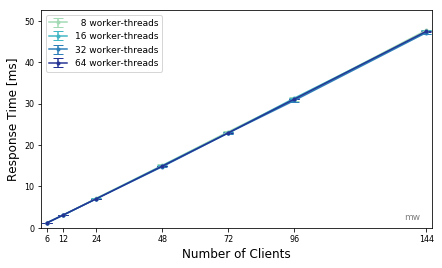

Saved Data: ./../../data/exp32/read_only/processed_mw.log
Saved Data: ./../../data/exp32/read_only/processed_client.log
MW: 


n_worker_per_mw          8                                                   \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2868.5  2956.1  2954.1  2947.2  2947.7  2954.2  2946.3   
rt_rep_mean             1.2     3.1     7.1    15.1    23.2    31.1    47.8   
qwt_rep_mean            0.1     0.1     2.1     9.7    17.8    25.7    42.3   
queue_rep_mean          0.1     0.1     2.2    14.8    27.9    37.7    63.0   

n_worker_per_mw          16                                                  \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2826.7  2951.7  2952.5  2950.2  2948.2  2946.3  2945.9   
rt_rep_mean             1.2     3.1     7.0    15.0    23.0    31.3    47.4   
qwt_rep_mean            0.1     0.1     0.2     4.6    12.1    20.5    36.5   
queue_rep_mean          0.1     0.2     0.7     7.3    19.4    31.6    53.9   

n_worker_per_mw          32                                                  \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2879.6  2948.5  2951.6  2952.1  2953.2  2952.0  2948.2   
rt_rep_mean             1.2     3.1     7.0    14.8    22.9    30.8    47.2   
qwt_rep_mean            0.1     0.1     0.2     0.5     2.7     9.4    25.5   
queue_rep_mean          0.1     0.3     0.2     0.7     4.4    14.9    36.2   

n_worker_per_mw          64                                                  
num_clients             6       12      24      48      72      96      144  
throughput_rep_mean  2880.9  2948.1  2954.2  2955.2  2960.9  2951.4  2945.2  
rt_rep_mean             1.2     3.1     7.0    14.9    23.0    31.1    47.5  
qwt_rep_mean            0.1     0.1     0.2     0.5     0.6     0.6     5.0  
queue_rep_mean          0.1     0.1     0.3     0.2     0.2     0.0     7.8

Client: 


n_worker_per_mw          8                                                   \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2826.9  2997.4  3063.8  3101.8  3081.9  3098.8  3076.9   
rt_rep_mean             2.1     4.0     7.9    15.5    23.4    31.1    46.8   

n_worker_per_mw          16                                                  \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2799.4  2995.8  3068.5  3078.3  3114.5  3111.2  3067.2   
rt_rep_mean             2.2     4.0     7.8    15.7    23.3    31.0    46.9   

n_worker_per_mw          32                                                  \
num_clients             6       12      24      48      72      96      144   
throughput_rep_mean  2838.0  3000.7  3124.1  3143.2  3108.6  3120.6  3138.5   
rt_rep_mean             2.1     4.0     7.7    15.3    23.2    30.9    45.9   

n_worker_per_mw          64                                                  
num_clients             6       12      24      48      72      96      144  
throughput_rep_mean  2844.8  3011.5  3085.2  3103.8  3105.7  3093.2  3121.3  
rt_rep_mean             2.1     4.0     7.8    15.5    23.2    31.1    46.4

In [15]:
df_exp32_ro_mw = df_exp32_mw[df_exp32_mw['workload']=='read-only']
df_exp32_ro_c = df_exp32_client[df_exp32_client['workload']=='read-only']

generate(tp.nc_w, df_exp32_ro_mw, output_folder, f"{exp_name}_ro_tp_nc_w") 
generate(rt.nc_w, df_exp32_ro_mw, output_folder, f"{exp_name}_ro_rt_nc_w")

export(df_exp32_ro_mw, "read_only", exp_name="exp32", suffix="_mw")
export(df_exp32_ro_c, "read_only", exp_name="exp32", suffix="_client")

print("MW: ")
display(df_exp32_ro_mw[['n_worker_per_mw', 'num_clients', 'throughput_rep_mean','rt_rep_mean', 'qwt_rep_mean', 'queue_rep_mean']].sort_values(['n_worker_per_mw', 'num_clients']).set_index(['n_worker_per_mw','num_clients']).transpose().round(1))

print("Client: ")
display(df_exp32_ro_c[['n_worker_per_mw', 'num_clients', 'throughput_rep_mean','rt_rep_mean']].sort_values(['n_worker_per_mw', 'num_clients']).set_index(['n_worker_per_mw','num_clients']).transpose().round(1))


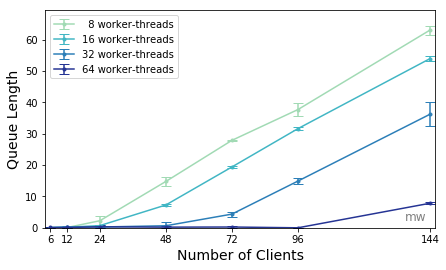

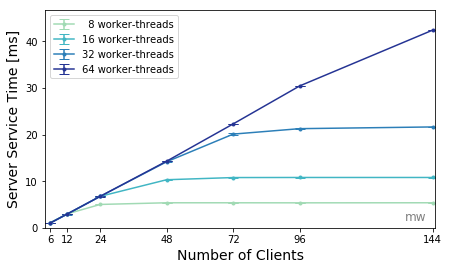

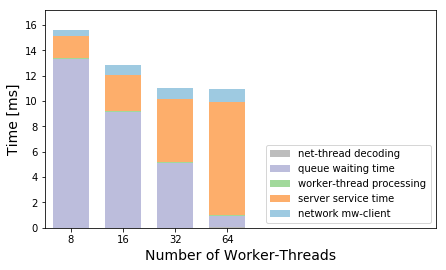

In [16]:
exp_name="exp32"
generate(queue.nc_w, df_exp32_ro_mw, output_folder, f"{exp_name}_ro_queue_nc_w", n_fig=3)
generate(sst.nc_w, df_exp32_ro_mw, output_folder, f"{exp_name}_ro_sst_nc_w", n_fig=3)
generate(rt.component_w, df[df['num_clients']==144], output_folder, f"{exp_name}_ro_rt_component_w",  n_fig=3)

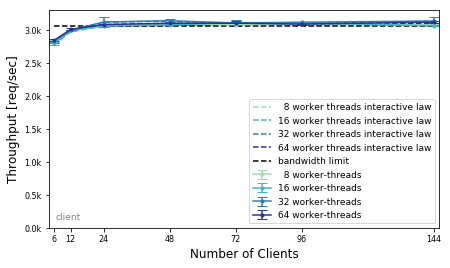

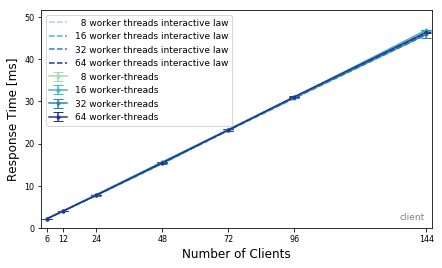

In [17]:
generate(tp.nc_w, df_exp32_ro_c)
generate(rt.nc_w, df_exp32_ro_c)

#### 3.2.1 Explanation

### 3.3 Summary